<a href="https://colab.research.google.com/github/yonghyeokrhee/personalize/blob/master/homeshopping_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import boto3
from decimal import Decimal
import json
import urllib
import io
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
%matplotlib inline
from botocore.exceptions import ClientError

In [ ]:
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
%matplotlib inline
import os
os.getcwd()

'C:\\Users\\user\\Documents'

In [ ]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
personalize = boto3.client(service_name='personalize', endpoint_url='https://personalize.us-west-2.amazonaws.com', region_name='us-west-2')
personalize_runtime = boto3.client(service_name='personalize-runtime', endpoint_url='https://personalize-runtime.us-west-2.amazonaws.com', region_name='us-west-2')

In [ ]:
files = ['20190613_1.csv','20190613_2.csv','20190613_3.csv',
         '20190613_4.csv','20190613_5.csv']

In [ ]:
df = pd.DataFrame()
for i in files:
    temp = pd.read_csv(i)
    df = pd.concat([df,temp])

In [ ]:
df.to_csv("raw_data_full.csv")

In [ ]:
s3 = boto3.Session().resource('s3')
my_bucket = s3.Bucket('personalize-dsc')

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object)

s3.ObjectSummary(bucket_name='personalize-dsc', key='DEMO-movie-lens-100k.csv')
s3.ObjectSummary(bucket_name='personalize-dsc', key='cartorzzim.csv')
s3.ObjectSummary(bucket_name='personalize-dsc', key='raw_data.csv')


In [ ]:
df = pd.read_csv('C:/Users/user/Downloads/raw_data.csv', index_col=0)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
zzim = pd.read_csv('cartorzzim.csv')

In [ ]:
zzim.head()

,TIMESTAMP,USER_ID,EVENT_TYPE,ITEM_ID,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,BRAND_NAME,BRAND_CODE,ITEM_NAME,ITEM_CODE,MD_NAME,MD_CODE
0,2019/01/01 00:00,201701443671,cart,10049381,패션,여성의류,아우터,코트,요하넥스,1648,요하넥스_코트,54376,의류,11
1,2019/01/01 00:00,201701503299,zzim,10061085,리빙,건강/헬스,건강매트,안마매트,메디칼드림,144,메디칼드림_안마매트,1160,리빙,31
2,2019/01/01 00:01,201602306115,cart,10060946,패션,여성의류,하의,데님,비지트인뉴욕,1634,비지트인뉴욕_데님,101643,의류,11
3,2019/01/01 00:01,201602309528,cart,10058998,패션,언더웨어,여성속옷,양말/스타킹/레깅스,비비안,2483,비비안_양말/스타킹/레깅스,101424,온라인,61
4,2019/01/01 00:01,201811491154,cart,10053689,주방,주방가전,조리기,튀김기,일렉트로맨,1852,일렉트로맨_튀김기,82550,주방,21


In [ ]:
zzim.rename(columns={'YYYYMMDDHHMI':'TIMESTAMP','CUST_NO':'USER_ID','GOODS_CODE':'ITEM_ID'}, inplace=True)

In [ ]:
zzim.rename(columns={'C_OR_Z':'EVENT_TYPE'}, inplace=True)

In [ ]:
df_times = df[['FIRST_ORDER_DATE','LAST_ORDER_DATE','ORDER_DATE']]

In [ ]:
df[['GOODS_NAME','SALE_PRICE','RSALE_AMT','CHANGE_RATE_AMT']].head()

,GOODS_NAME,SALE_PRICE,RSALE_AMT,CHANGE_RATE_AMT
0,[반값딜] 카밀 핸드크림 클래식 1+1,8500,4250,3953
1,(홀리데이 구성) 엘렌실라 달팽이크림 50g*5개 + EGF크림 50g*5개 + 파...,79000,78000,63960
2,김나운 손질새우 140g(20미)/팩 x 13팩 (총 260미),60900,59900,50915
3,백년의삶 동안석류즙 70ml*105포 (N035),79900,78900,63909
4,(고객감사특가) 럭키샵 마르조 리버시블 항공점퍼 1+1,39800,38800,22504


In [ ]:
df[['SALE_PRICE','DC_ARS', 'DC_NOREST', 'DC_GOODS', 'DC_COUPON', 'DC_AMT_PARTNER',
       'RSALE_AMT', 'CHANGE_RATE_AMT']].head()

,SALE_PRICE,DC_ARS,DC_NOREST,DC_GOODS,DC_COUPON,DC_AMT_PARTNER,RSALE_AMT,CHANGE_RATE_AMT
0,8500,0,0,4250,0,0,4250,3953
1,79000,1000,0,0,0,0,78000,63960
2,60900,1000,0,0,0,0,59900,50915
3,79900,1000,0,0,0,0,78900,63909
4,39800,1000,0,0,0,0,38800,22504


In [ ]:
batch = df[['GOODS_CODE','GOODS_NAME','LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'MD_CODE', 'MD_NAME', 'BRAND_CODE',
       'BRAND_NAME', 'ITEM_CODE', 'ITEM_NAME', 'SALE_PRICE', 'SALE_GB',
       'ORDER_DATE', '방송주문여부', 'ORDER_MEDIA',
       'CUST_NO', 'BIRTHDAY', 'SEX', 'ADDR',
       'CUST_GB_NM', 'WITHDRAWAL_YN', 'CUST_INSERT_DATE', 'INSERT_MEDIA',
       'MEMB_GB', 'FIRST_ORDER_DATE', 'LAST_ORDER_DATE', 'SH_MAN_ID',
       'SH_MAN_NAME', 'SH_SUB_ID', 'SH_SUB_NAME']].copy()

In [ ]:
users = batch[['CUST_NO','BIRTHDAY','SEX','ADDR','CUST_GB_NM','CUST_INSERT_DATE','FIRST_ORDER_DATE','LAST_ORDER_DATE']]

In [ ]:
users.loc[:,'BIRTHDAY'] = pd.to_datetime(users.BIRTHDAY, format='%Y%m', errors='coerce')
users.loc[:,'CUST_INSERT_DATE'] = pd.to_datetime(users.CUST_INSERT_DATE).dt.date
users.loc[:,'FIRST_ORDER_DATE'] = pd.to_datetime(users.FIRST_ORDER_DATE).dt.date
users.loc[:,'LAST_ORDER_DATE'] = pd.to_datetime(users.LAST_ORDER_DATE).dt.date

In [ ]:
users['age'] = users['BIRTHDAY'].apply(lambda x: now - x)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data overflow (memory out)
now = pd.Timestamp('now')
now - users.BIRTHDAY[:100]

0    14269 days 11:12:42.103263
1    17983 days 11:12:42.103263
2    20234 days 11:12:42.103263
3    22913 days 11:12:42.103263
4    19169 days 11:12:42.103263
5    22913 days 11:12:42.103263
6    19230 days 11:12:42.103263
7    18988 days 11:12:42.103263
8    19230 days 11:12:42.103263
9    16734 days 11:12:42.103263
10   20783 days 11:12:42.103263
11   18591 days 11:12:42.103263
12   20661 days 11:12:42.103263
13   18713 days 11:12:42.103263
14   24557 days 11:12:42.103263
15   24557 days 11:12:42.103263
16   21818 days 11:12:42.103263
17   24557 days 11:12:42.103263
18   21726 days 11:12:42.103263
19   20144 days 11:12:42.103263
20   20144 days 11:12:42.103263
21   17465 days 11:12:42.103263
22   23827 days 11:12:42.103263
23   23827 days 11:12:42.103263
24   23827 days 11:12:42.103263
25   17861 days 11:12:42.103263
26   23827 days 11:12:42.103263
27   24954 days 11:12:42.103263
28   21270 days 11:12:42.103263
29   19444 days 11:12:42.103263
                ...            
70   259

In [ ]:
users['AGE'] = users['age'].apply(lambda x: np.round(x.days / 365))

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
users.loc[:,'AGE'] = users['AGE'].where(users['AGE'] < 100, None)

In [ ]:
users.loc[:,'AGE'] = users['AGE'].where(users['AGE'] > 0, None)

### purchase frequency column is added

In [ ]:
pur_freq = users.groupby('CUST_NO').size().rename('freq')

In [ ]:
users1 = users[['CUST_NO','AGE','SEX','ADDR','CUST_GB_NM']].set_index('CUST_NO').join(pur_freq).copy()

In [ ]:
#be careful with drop_duplicates()
#USERS = users1.drop_duplicates().reset_index()

In [ ]:
USERS = users1.reset_index().drop_duplicates(subset='CUST_NO')

(array([1.10000e+01, 2.74000e+03, 5.24630e+04, 2.00369e+05, 4.06068e+05,
        6.86568e+05, 3.72770e+05, 8.00260e+04, 8.85500e+03, 3.05000e+02]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

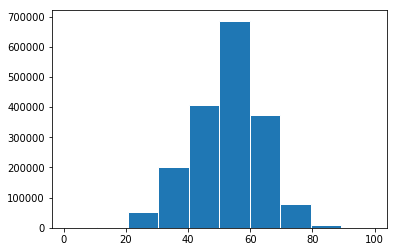

In [ ]:
plt.hist(USERS.AGE.dropna().to_list(),edgecolor='w')

In [ ]:
USERS.rename(columns={'CUST_NO':'USER_ID'},inplace=True)

In [ ]:
#USERS.SEX.astype('category')

In [ ]:
USERS.AGE.fillna(USERS.AGE.mean(), inplace=True)

In [ ]:
USERS.rename(columns={'CUST_GB_NM':'CUST_GB_NAME'}, inplace=True)

In [ ]:
USERS.loc[:,'AGE']=USERS.AGE.astype('int64')

In [ ]:
USERS.to_csv('user_age_sex_freq.csv')

In [ ]:
schema = {
  "type": "record",
  "name": "Users",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
      {
          "name": "USER_ID",
          "type": "string"
      },
      {
          "name": "AGE",
          "type": "int"
      },
      {
          "name": "SEX",
          "type": "string",
          "categorical": True
      },
      {
          "name": "ADDR",
          "type": "string",
          "categorical": True
      },
      {
          "name": "CUST_GB_NAME",
          "type": "string",
          "categorical": True
      },
      {
          "name": "freq",
          "type": "int"
      }
  ],
  "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "users_age_sex_freq",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/users_age_sex_freq",
  "ResponseMetadata": {
    "RequestId": "d42da348-efb2-42b1-821c-c428742fd90f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 26 Jun 2019 05:02:49 GMT",
      "x-amzn-requestid": "d42da348-efb2-42b1-821c-c428742fd90f",
      "content-length": "84",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "hrnn_meta_second_event_type"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-west-2:351072964306:dataset-group/hrnn_meta_second_event_type",
  "ResponseMetadata": {
    "RequestId": "418f67c4-5c45-45e7-88e9-d97a04493229",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:49:58 GMT",
      "x-amzn-requestid": "418f67c4-5c45-45e7-88e9-d97a04493229",
      "content-length": "106",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


In [ ]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "users_age_sex_freq",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/users_age_sex_freq"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/USERS",
  "ResponseMetadata": {
    "RequestId": "675373c4-1d00-48ab-9b57-fb5a86b9adad",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:50:39 GMT",
      "x-amzn-requestid": "675373c4-1d00-48ab-9b57-fb5a86b9adad",
      "content-length": "101",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
role_arn = "arn:aws:iam::351072964306:role/PersonalizeS3Role"

In [ ]:
bucket = 'personalize-dsc'

In [ ]:
filename = 'user_age_sex_freq.csv'

In [ ]:
USERS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170315 entries, 0 to 3448759
Data columns (total 6 columns):
USER_ID         int64
AGE             int64
SEX             object
ADDR            object
CUST_GB_NAME    object
freq            int64
dtypes: int64(3), object(3)
memory usage: 115.9+ MB


In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "user-import-job-3",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/USERS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'user_age_sex_freq.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/user-import-job-3",
  "ResponseMetadata": {
    "RequestId": "e753774d-4111-49ea-bd25-332253a9369f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:52:47 GMT",
      "x-amzn-requestid": "e753774d-4111-49ea-bd25-332253a9369f",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### INTERACTIONS

1. no cart data

In [ ]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "interactions",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/interactions",
  "ResponseMetadata": {
    "RequestId": "b49bc9e2-19c1-4388-b7f5-dd40eca039d7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 26 Jun 2019 05:24:20 GMT",
      "x-amzn-requestid": "b49bc9e2-19c1-4388-b7f5-dd40eca039d7",
      "content-length": "78",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


2. Cart Data

In [ ]:
schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "interactions-event-type",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/interactions-event-type",
  "ResponseMetadata": {
    "RequestId": "3b335abc-157f-4919-b1b3-dc419f3bea9d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:48:40 GMT",
      "x-amzn-requestid": "3b335abc-157f-4919-b1b3-dc419f3bea9d",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
df[['GOODS_CODE','CUST_NO','ORDER_DATE']].head()

,GOODS_CODE,CUST_NO,ORDER_DATE
0,10060956,201611266992,2019/01/14 11:47
1,10056895,201608923519,2019/01/21 20:07
2,10062781,201601299917,2019/01/18 17:23
3,10050745,201605742571,2019/01/16 23:23
4,10050867,201601282310,2019/01/28 22:25


In [ ]:
z = zzim[['USER_ID','ITEM_ID','TIMESTAMP','EVENT_TYPE']][zzim.USER_ID.isin(USERS.USER_ID)]

In [ ]:
inter = df[['CUST_NO','GOODS_CODE','ORDER_DATE']].copy()

In [ ]:
inter.rename(columns = {'CUST_NO':'USER_ID','GOODS_CODE':'ITEM_ID','ORDER_DATE':'TIMESTAMP'},inplace=True)

In [ ]:
inter['EVENT_TYPE'] = 'sale'

In [ ]:
interaction = pd.concat([inter,z], axis=0)

In [ ]:
interaction.loc[:,'TIMESTAMP'] = pd.to_datetime(interaction.TIMESTAMP).astype('int64')

In [ ]:
interaction.to_csv('interactions.csv')

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "zzim_and_sale",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/interactions-event-type"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "3d80a1c1-4472-4fe7-ab67-262c668f87c0",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:51:11 GMT",
      "x-amzn-requestid": "3d80a1c1-4472-4fe7-ab67-262c668f87c0",
      "content-length": "108",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
filename = 'interactions.csv'

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "interaction-import-job2",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/INTERACTIONS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'interactions.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/interaction-import-job2",
  "ResponseMetadata": {
    "RequestId": "f632cc0e-c863-43cc-bdd2-ce3c5db0648c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:54:11 GMT",
      "x-amzn-requestid": "f632cc0e-c863-43cc-bdd2-ce3c5db0648c",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### ITEM meta data

In [ ]:
items = df[['GOODS_CODE', 'LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'MD_CODE', 'BRAND_CODE',
       'ITEM_CODE', 'SALE_PRICE', 'SALE_GB','SH_MAN_ID',
       'SH_SUB_ID']].rename(columns={'GOODS_CODE':'ITEM_ID'})

In [ ]:
items.loc[:,'SH_MAN_ID'] = items.SH_MAN_ID.fillna('SSG')
items.loc[:,'SH_SUB_ID'] = items.SH_SUB_ID.fillna('SSG')

In [ ]:
items.to_csv('items_all.csv')

In [ ]:
items[['ITEM_ID', 'LGROUP_NAME', 'MGROUP_NAME', 'SGROUP_NAME','BRAND_CODE']].to_csv('item_first.csv')

In [ ]:
items[['ITEM_ID', 'LGROUP_NAME', 'MGROUP_NAME', 'SGROUP_NAME','BRAND_CODE']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3448760 entries, 0 to 697427
Data columns (total 5 columns):
ITEM_ID        int64
LGROUP_NAME    object
MGROUP_NAME    object
SGROUP_NAME    object
BRAND_CODE     int64
dtypes: int64(2), object(3)
memory usage: 157.9+ MB


In [ ]:
schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "LGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "MGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "SGROUP_NAME",
            "type": "string",
            "categorical": True
        },
        {
            "name": "BRAND_CODE",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "items-first",
    schema = json.dumps(schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-west-2:351072964306:schema/items-first",
  "ResponseMetadata": {
    "RequestId": "596572fd-3d24-4b07-9f45-5868c01480a6",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Wed, 26 Jun 2019 07:11:32 GMT",
      "x-amzn-requestid": "596572fd-3d24-4b07-9f45-5868c01480a6",
      "content-length": "77",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "item_all_categories",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = "arn:aws:personalize:us-west-2:351072964306:schema/items-first"
)

dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/ITEMS",
  "ResponseMetadata": {
    "RequestId": "ac95ca1c-49a9-4891-b6ea-27b9c788a3ca",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:51:24 GMT",
      "x-amzn-requestid": "ac95ca1c-49a9-4891-b6ea-27b9c788a3ca",
      "content-length": "101",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
filename = 'item_first.csv'

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(filename).upload_file(filename)

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "item-import-job-2",
    datasetArn = "arn:aws:personalize:us-west-2:351072964306:dataset/hrnn_meta_second_event_type/ITEMS",
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, 'item_first.csv')
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/item-import-job-2",
  "ResponseMetadata": {
    "RequestId": "2e548a53-7207-4bbd-9b37-ebb4d5c27b62",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 01:54:56 GMT",
      "x-amzn-requestid": "2e548a53-7207-4bbd-9b37-ebb4d5c27b62",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### describe dataset_import_job response

In [ ]:
status = None
max_time = time.time() + 3*60*60
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
    datasetImportJobArn = "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/interaction-import-job2"

#        dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: ACTIVE


In [ ]:
describe_dataset_import_job_response = personalize.describe_dataset_import_job(
    datasetImportJobArn = "arn:aws:personalize:us-west-2:351072964306:dataset-import-job/item-import-job-2"
)
status = describe_dataset_import_job_response["datasetImportJob"]['status']
print("DatasetImportJob: {}".format(status))

DatasetImportJob: CREATE IN_PROGRESS


### Create Solution

In [ ]:
list_recipes_response = personalize.list_recipes()

In [ ]:
recipe_arn = "arn:aws:personalize:::recipe/aws-hrnn-metadata"

In [ ]:
create_solution_response = personalize.create_solution(
    name= "solution-hrnn-meta-second",
    datasetGroupArn = dataset_group_arn,
    recipeArn = recipe_arn
)
solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-west-2:351072964306:solution/solution-hrnn-meta-second",
  "ResponseMetadata": {
    "RequestId": "020080f9-697e-4986-bb48-f2a8530f795e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 02:09:09 GMT",
      "x-amzn-requestid": "020080f9-697e-4986-bb48-f2a8530f795e",
      "content-length": "95",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = solution_arn)

solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-west-2:351072964306:solution/solution-hrnn-meta-second/be345216",
  "ResponseMetadata": {
    "RequestId": "c6d5533a-b4ad-4033-9b4a-c8cc5c4fb183",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 02:09:15 GMT",
      "x-amzn-requestid": "c6d5533a-b4ad-4033-9b4a-c8cc5c4fb183",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
status = None
max_time = time.time() + 3*60*60
while time.time() < max_time:
    describe_solution_version_response = personalize.describe_solution_version(
        solutionVersionArn = solution_version_arn
    )
    status = describe_solution_version_response["solutionVersion"]["status"]
    print("SolutionVersion: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

SolutionVersion: CREATE PENDING
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGRESS
SolutionVersion: CREATE IN_PROGR

In [ ]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-west-2:351072964306:solution/solution-hrnn-meta-second/be345216",
  "metrics": {
    "coverage": 0.0639,
    "mean_reciprocal_rank_at_25": 0.139,
    "normalized_discounted_cumulative_gain_at_10": 0.1788,
    "normalized_discounted_cumulative_gain_at_25": 0.2036,
    "normalized_discounted_cumulative_gain_at_5": 0.1588,
    "precision_at_10": 0.0242,
    "precision_at_25": 0.0137,
    "precision_at_5": 0.0367
  },
  "ResponseMetadata": {
    "RequestId": "3281a3f2-9bd0-48d7-8f3a-63dac271b6b2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 27 Jun 2019 06:07:04 GMT",
      "x-amzn-requestid": "3281a3f2-9bd0-48d7-8f3a-63dac271b6b2",
      "content-length": "408",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
onsale_item = len(df[onsale].GOODS_CODE.unique())

In [ ]:
order_date = df[onsale][['GOODS_CODE','CUST_NO','ORDER_DATE']].set_index(['CUST_NO','GOODS_CODE'])

In [ ]:
order_cleaned = df[onsale][['GOODS_CODE','CUST_NO','ORDER_DATE']].drop_duplicates(subset=['GOODS_CODE','CUST_NO'])

In [ ]:
order_cleaned.set_index(['CUST_NO','GOODS_CODE']).unstack()

In [ ]:
(len(order_date)/ (onsale_item * len_cust))*100453512

0.008259361717457349

In [ ]:
len(df[df['SALE_GB'] == '진행']['GOODS_CODE'].unique())

12339

In [ ]:
df.FIRST_ORDER_DATE.isna().sum()

329156

In [ ]:
df1 = df.dropna(subset=['FIRST_ORDER_DATE']).copy()

In [ ]:
len(df.ORDER_DATE)

3242479

 재구매 고객

In [ ]:
df.LAST_ORDER_DATE.head()

0    2019.1.14
1    2019.1.21
2    2019.2.15
3    2019.1.31
4    2019.1.31
Name: LAST_ORDER_DATE, dtype: object

In [ ]:
cust_ret = df[df.LAST_ORDER_DATE != df.ORDER_DATE]

기존 고객

In [ ]:
cust_ret.head()

,ORDER_NO,GOODS_CODE,GOODS_NAME,LGROUP_NAME,MGROUP_NAME,SGROUP_NAME,DGROUP_NAME,SALE_PRICE,SALE_GB,ORDER_DATE,...,BIRTHDAY,SEX,ADDR,CUST_GB_NM,WITHDRAWAL_YN,CUST_INSERT_DATE,INSERT_MEDIA,MEMB_GB,FIRST_ORDER_DATE,LAST_ORDER_DATE
0,20190114221750,10060956,[반값딜] 카밀 핸드크림 클래식 1+1,뷰티,이미용품,바디용품,핸드크림,8500,진행,2019-01-14,...,198006.0,여,강원도/동해시,회원,0,2016.11.19,모바일,일반,2016.11.19 13:56,2019.1.14
1,20190121274335,10056895,(홀리데이 구성) 엘렌실라 달팽이크림 50g*5개 + EGF크림 50g*5개 + 파...,뷰티,화장품,기초화장품,기초세트,79000,판매중단,2019-01-21,...,197004.0,여,강원도/동해시,회원,0,2016.8.30,ARS자동,일반,2016.8.30 20:09,2019.1.21
2,20190123337551,10065231,[초특가](여성)험멜 패딩자켓+덕다운베스트 2종 세트,패션,스포츠레저캠핑,스포츠의류,다운/패딩,49000,판매중단,2019-01-23,...,196208.0,여,강원도/동해시,회원,0,2016.5.20,상담사,일반,2016.5.20 17:27,2019.2.15
3,20190131416677,10065090,(설) 나주고깃간 LA갈비 500g*9팩 (총4.5KG) (N033),식품,가공식품,축산가공식품,세트,89900,진행,2019-01-31,...,196611.0,여,강원도/동해시,회원,0,2015.8.12,상담사,일반,2015.8.12 13:39,2019.1.31
4,20190131407599,10060442,2018FW 푸마 웜셀 긴팔형 기모브라탑 4종,패션잡화,언더웨어,여성속옷,내의,69000,판매중단,2019-01-31,...,196611.0,여,강원도/동해시,회원,0,2015.8.12,상담사,일반,2015.8.12 13:39,2019.1.31


In [ ]:
cust_old = df1[df1.LAST_ORDER_DATE != df1.FIRST_ORDER_DATE]

In [ ]:
print(len(cust_ret.CUST_NO.unique()))

NameError: name 'cust_ret' is not defined

In [ ]:
print(len(cust_old.CUST_NO.unique()))

1154466


In [ ]:
(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]').sum()/cust_ret.shape[0]

49.25108501865604

In [ ]:
(df_re.LAST_ORDER_DATE - df_re.FIRST_ORDER_DATE).astype('timedelta64[D]').sum()/2280863

574.5952843287826

(0, 141.75)

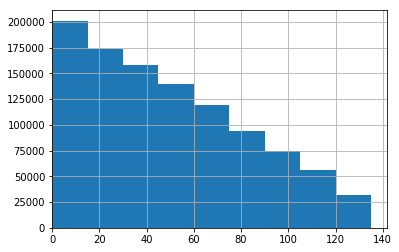

In [ ]:
(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]').hist(bins=np.arange(0,150,15))
plt.xlim(0,)

In [ ]:
cust_ret_clean = cust_ret[(cust_ret.LAST_ORDER_DATE - cust_ret.ORDER_DATE).astype('timedelta64[D]') > 0]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
(cust_ret_clean.LAST_ORDER_DATE - cust_ret_clean.ORDER_DATE).astype('timedelta64[D]').value_counts().to_csv('return_cust.csv')

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
(cust_ret_clean.LAST_ORDER_DATE - cust_ret_clean.ORDER_DATE).astype('timedelta64[D]').value_counts(bins=np.arange(0,150,15))

(-0.001, 15.0]    213431
(15.0, 30.0]      171852
(30.0, 45.0]      157144
(45.0, 60.0]      138576
(60.0, 75.0]      118003
(75.0, 90.0]       93044
(90.0, 105.0]      73499
(105.0, 120.0]     54327
(120.0, 135.0]     29195
dtype: int64

In [ ]:
cust_ret_clean['GOODS_NAME'].value_counts()

NameError: name 'cust_ret_clean' is not defined

In [ ]:
df['GOODS_NAME'].value_counts()[:20].to_csv('value_count_top20.csv', encoding='korean')

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
top_20_items = df['GOODS_NAME'].value_counts().index[:20]

In [ ]:
top_20_df = df.set_index('GOODS_NAME').loc[top_20_items]

In [ ]:
top_20_df = top_20_df.reset_index().drop_duplicates(subset='GOODS_NAME')

In [ ]:
top_20_df.iloc[:, [0,3,4,5,6,8]].to_csv('top_20_df.csv', encoding='korean')

In [ ]:
top_20_df.columns

Index(['GOODS_NAME', 'ORDER_NO', 'GOODS_CODE', 'LGROUP_NAME', 'MGROUP_NAME',
       'SGROUP_NAME', 'DGROUP_NAME', 'SALE_PRICE', 'SALE_GB', 'ORDER_DATE',
       '방송주문여부', 'ORDER_MEDIA', 'SETTLE_NAME', 'CARD_NAME', 'DC_ARS',
       'DC_NOREST', 'DC_GOODS', 'DC_COUPON', 'DC_AMT_PARTNER', 'RSALE_AMT',
       'CUST_NO', 'BIRTHDAY', 'SEX', 'ADDR', 'CUST_GB_NM', 'WITHDRAWAL_YN',
       'CUST_INSERT_DATE', 'INSERT_MEDIA', 'MEMB_GB', 'FIRST_ORDER_DATE',
       'LAST_ORDER_DATE'],
      dtype='object')

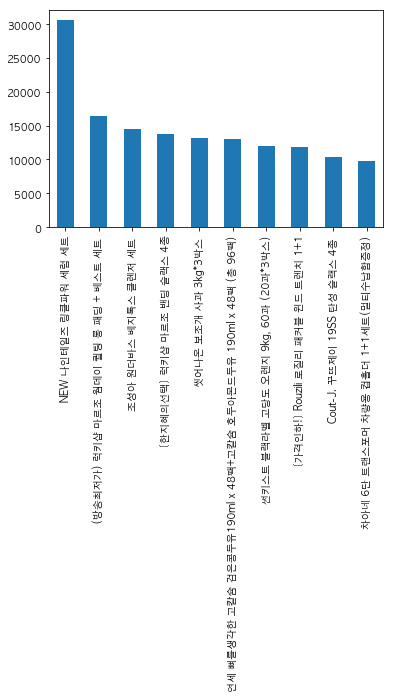

In [ ]:
cust_ret_clean['GOODS_NAME'].value_counts()[:10].plot(kind='bar')